In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import os
import numpy as np
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn.utils import clip_grad_norm_
from utils.func_utils import normal_kl, gen_data, vae_loss
from utils.dynamics import Dynamics
from model import VAE, Encoder, Decoder, Net
from tqdm import tqdm_notebook

from utils.func_utils import gen_data, binarize, normal_kl
from utils.sampler import propose,  chain_operator

from itertools import chain
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
epoch=100
leapfrogs=5
mh_steps=5
batch_size=512
latent_dim=50
update_sampler_every=1
eval_samples_every=1
random_lf_composition=0
stop_gradient=False
hmc=False
eps=0.1
energy_scale=0.

In [4]:
test_loader, train_loader = gen_data(batch_size=512) 

encoder_sampler = Decoder(784, 200, 512)
base_vae = VAE(784, 50, 1024)
base_vae.cuda(1);

def energy(z, aux=None):
    logits = base_vae.decoder(z)        
    log_posterior = -torch.sum(F.binary_cross_entropy_with_logits(logits, aux, reduction='none'), 1)
    log_prior = -0.5 * torch.sum(z**2,1)
    return (-log_posterior - log_prior)

dynamics = Dynamics(latent_dim, energy, T=5, eps=0.1, net_factory=Net, encoder_sampler=encoder_sampler, size1=200, size2=200)

optimizer = torch.optim.Adam(base_vae.parameters(), lr=0.001)
optimizer_sampler = torch.optim.Adam(chain(dynamics.XNet.parameters(), dynamics.VNet.parameters()), lr=0.001)

In [5]:
for i in  tqdm_notebook(range(epoch)):
    for x in train_loader:
        
        x = x[0].cuda(1)
        logits, mu, log_sigma = base_vae(x)
        elbo = vae_loss(mu.cpu(), log_sigma.cpu(), logits.cpu(), x.cpu())
        latent_q = base_vae.z
        
        init_x = latent_q.data
        init_v = torch.randn(init_x.shape)

        for t in range(mh_steps):
            inverse_term = 0.
            other_term = 0.
            energy_loss = 0.

            if stop_gradient:
                init_x = init_x.data
            if random_lf_composition > 0:
                nb_steps = torch.Tensor.uniform_(1, random_lf_composition).int()
                final_x, _, px, MH = chain_operator(init_x, dynamics, nb_steps, aux=x, do_mh_step=True)
                energy_loss = 0.
            else:
                inverse_term = 0.
                other_term = 0.
                final_x, _, px, MH = propose(init_x, dynamics, aux=x, do_mh_step=True)

            # distance
            v = (final_x - init_x)**2 / ((torch.exp(2 * log_sigma)).data + 1e-4)    
            v = torch.sum(v, 1) * px + 1e-4

            # energy
            energy_diff = (energy(final_x, aux=x) - energy(init_x, aux=x))**2 * px + 1e-4
            inverse_term += 1.0 / mh_steps * torch.mean(1.0 / v)
            other_term -= 1.0 / mh_steps * torch.mean(v)
            energy_loss += 1.0 / mh_steps * (torch.mean(1.0 / energy_diff) - torch.mean(energy_diff))

            init_x = MH[0].data

        latent_T = init_x
        sampler_loss = inverse_term + other_term + energy_scale * energy_loss

        logits_T = base_vae.decoder(latent_T.data)
        partition = torch.tensor(np.sqrt((2 * np.pi) ** latent_dim)).float()
        prior_probs = torch.log(partition.cuda(1)) + 0.5 * torch.sum(latent_T.data**2, 1)
        posterior_probs = torch.sum(F.binary_cross_entropy_with_logits(logits_T, x, reduction='none'), 1).cuda(1)
        likelihood = torch.mean(prior_probs + posterior_probs, 0)
        
        optimizer.zero_grad()
        elbo.backward()
        likelihood.backward()
        optimizer.step()
        
        if not hmc:
            optimizer_sampler.zero_grad()
            sampler_loss.backward()
            clip_grad_norm_(chain(dynamics.XNet.parameters(), dynamics.VNet.parameters()), 5)
            optimizer_sampler.step()

A Jupyter Widget

In [6]:
torch.save(base_vae.cpu().state_dict(), './base_vae_100epochs.pth.tar')
torch.save(dynamics.XNet.cpu().state_dict(), './dynamics_XNet_100epochs.pth.tar')
torch.save(dynamics.XNet.cpu().state_dict(), './dynamics_VNet_100epochs.pth.tar')

base_vae.cuda(1)
dynamics.XNet.cuda(1)
dynamics.VNet.cuda(1);

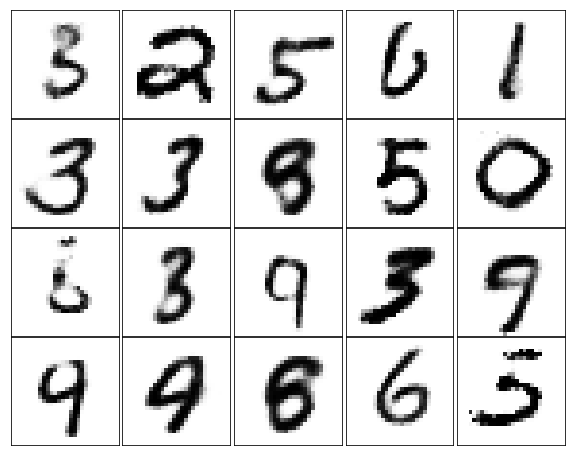

In [23]:
base_vae.cpu()
fig1, ax = plt.subplots(4,5,figsize=(10,8))
for i in range(20):
    s = base_vae.sample(torch.randn((1, 50)))
    ax[i//5, i%5].imshow(np.array(s.data.cpu()).reshape(28,28), cmap='gray_r')
    ax[i//5, i%5].set_xticks([])
    ax[i//5, i%5].set_yticks([])
plt.subplots_adjust(wspace=0.0005, hspace=0.01)

In [24]:
fig1.savefig('l2hmc_vae.png',bbox_inches='tight')

In [10]:
from utils.sampler import chain_operator, propose, t_accept
from utils.dynamics import Dynamics
from utils.func_utils import autocovariance

In [11]:
MH_STEPS = 1000

In [12]:
test_loader, train_loader = gen_data(batch_size=100) 
base_vae.cuda(1)
base_vae.eval()
dynamics.XNet.eval()
dynamics.VNet.eval()

for sampl in test_loader:
    break
x_0 = np.tile(sampl[0][0], (100, 1))
logits, mu, log_sigma = base_vae(torch.tensor(x_0).cuda(1))
latent_q = base_vae.z
nb_steps = torch.randint( low=0,high=4, size=(1,))
init_chain = latent_q

list_samples = []
for t in tqdm_notebook(range(MH_STEPS)):
    _, _, _, MH = chain_operator(latent_q.cuda(1), dynamics, nb_steps, do_mh_step=True, aux=torch.tensor(x_0).cuda(1))
    list_samples.append(MH[0].data.cpu())
    latent_q = MH[0].data

FF = np.array(list(map(lambda x: x.data.numpy(),list_samples)))
mu_ = FF[MH_STEPS // 2 :,:,:].mean(axis=(0,1))

A Jupyter Widget

A Jupyter Widget

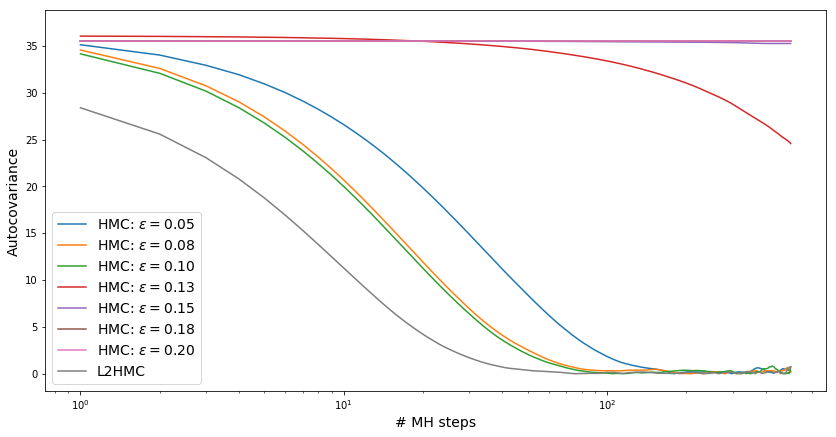

In [14]:
fig2 = plt.figure(figsize=(14,7))
for eps in tqdm_notebook(np.arange(0.05, 0.2, 0.025)):
    hmc_dynamics = Dynamics(50, energy, T=5, eps=eps, hmc=True)
    hmc_samples = []
    samples = init_chain
    
    for t in range(MH_STEPS):     
        _, _, _, MH_HMC = propose(samples.cuda(1), hmc_dynamics, do_mh_step=True, aux=torch.tensor(x_0).cuda(1))   
        samples = MH_HMC[0].data
        hmc_samples.append(MH_HMC[0].data.cpu().numpy())
        
    G = np.array(hmc_samples[MH_STEPS // 2:])
    plt.plot(np.abs([autocovariance(G - mu_, tau=t) for t in range(MH_STEPS // 2-1)]), label='HMC: $\epsilon=%.2f$' % eps)
    
plt.plot(np.abs([autocovariance(FF[MH_STEPS // 2:, :, :] - mu_, tau=t) for t in range(MH_STEPS // 2-1)]), label='L2HMC')
plt.xlabel('# MH steps', fontsize=14)
plt.ylabel('Autocovariance', fontsize=14)
plt.xscale('log')
plt.legend(fontsize=14);

In [15]:
fig2.savefig('autocovariance.png',bbox_inches='tight')

##### AIS

In [31]:
from utils.ais import ais_estimate
from utils.distributions import Gaussian

In [32]:
test_loader, train_loader = gen_data(batch_size=50) 

In [36]:
latent_dim = 50
anneal_steps = 50
leapfrogs = 10
N=10000
num_splits=50
base_vae.cuda(1)

gaussian = Gaussian(torch.zeros(latent_dim).cuda(1), torch.eye(latent_dim).cuda(1))
init_energy = gaussian.get_energy_function()

est_log_p = []

for ais_batch in tqdm_notebook(test_loader):
    ais_batch = ais_batch[0].cuda(1)
    ais_batch = ais_batch[:, None, :] + torch.zeros([1, 20, 1]).float().cuda(1)
    ais_batch = ais_batch.view(-1, 784)
    z = torch.randn(ais_batch.shape[0], latent_dim).cuda(1)
    p_x_hat = ais_estimate(init_energy, energy, anneal_steps, z, x_dim=latent_dim,
                           aux=ais_batch, leapfrogs=leapfrogs, step_size=0.1, num_splits=50)
    est_log_p.append(p_x_hat[0].cpu().data)

A Jupyter Widget

In [38]:
print('AIS:', sum(est_log_p) / N)

AIS: tensor(-29.3218)
